In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Serving PyTorch image models with prebuilt containers on Vertex AI


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/prediction/pytorch_image_classification_with_prebuilt_serving_containers.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/prediction/pytorch_image_classification_with_prebuilt_serving_containers.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/prediction/pytorch_image_classification_with_prebuilt_serving_containers.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

## Overview

This tutorial demonstrates how to upload and deploy a PyTorch image model using a prebuilt serving container and how to make online and batch predictions.

Vertex AI provides prebuilt containers for serving predictions and explanations from trained model artifacts. Using a pre-built container is generally simpler than creating your own custom container for prediction.

Learn more about [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers).

### Objective

In this tutorial, you learn how to package and deploy a PyTorch image classification model using a prebuilt Vertex AI container with TorchServe for serving online and batch predictions.

This tutorial uses the following Google Cloud ML services and resources:

- `Vertex AI Model Registry`
- `Vertex AI Model` resources
- `Vertex AI Endpoint` resources

The steps performed include:

- Download a pretrained image model from PyTorch
- Create a custom model handler
- Package model artifacts in a model archive file
- Upload model for deployment
- Deploy model for prediction
- Make online predictions
- Make batch predictions

### Model

This tutorial uses a pretrained image model [resnet18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html) from the PyTorch TorchVision.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [2]:
# ! pip3 install --upgrade --quiet google-cloud-aiplatform==1.23.0 \
#                                  tensorflow==2.12.0 \
#                                  torch==2.0.0 \
#                                  torchvision==0.15.1 \
#                                  torch-model-archiver==0.7.1 \
#                                  packaging==14.3

!pip install torchserve torch-model-archiver google-cloud-aiplatform packaging torch torchvision tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 791.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 336.0/410.6 MB 9.3 MB/s eta 0:00:08ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 336.0/410.6 MB 9.3 MB/s eta 0:00:08


### Colab only: Uncomment the following cell to restart the kernel.

In [3]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)


import torch
import torchvision

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, see the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [4]:
PROJECT_ID = "cmpt756-final-project-pose"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [5]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [6]:
from google.colab import auth
auth.authenticate_user()

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [8]:
BUCKET_URI = f"gs://vertex-ai-torch-{PROJECT_ID}-unique"
print(BUCKET_URI)

gs://vertex-ai-torch-cmpt756-final-project-pose-unique


**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [9]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://vertex-ai-torch-cmpt756-final-project-pose-unique/...


### Import libraries

In [10]:
import base64
import json
import os
import pathlib
import urllib.request

import tensorflow as tf
import torch
from google.cloud import aiplatform
from PIL import Image
from torchvision import models

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [11]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Download a pre-trained image model

Download the pretrained image model [resnet18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html) from the PyTorch TorchVision.

In [14]:
# Create a local directory for model artifacts
model_path = "model"

!rm -r $model_path
!mkdir $model_path

model_name = "resnet-18-custom-handler"
model_file = f"{model_path}/{model_name}.pt"

In [15]:
# Use scripted mode to save the PyTorch model locally
model = models.resnet18(pretrained=True)
script_module = torch.jit.script(model)
script_module.save(model_file)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


## Create a custom model handler

A custom model handler is a Python script that you package with the model when you use the model archiver. The script typically defines how to pre-process input data, invoke the model and post-process the output.

TorchServe has [default handlers](https://pytorch.org/serve/default_handlers.html) for `image_classifier`, `image_segmenter`, `object_detector` and `text_classifier`. In this tutorial, you create a custom handler extending the default [`image_classifier`](https://github.com/pytorch/serve/blob/master/ts/torch_handler/image_classifier.py) handler.


In [16]:
hander_file = f"{model_path}/custom_handler.py"

In [17]:
%%writefile {hander_file}

import torch
import torch.nn.functional as F
from ts.torch_handler.image_classifier import ImageClassifier
from ts.utils.util import map_class_to_label


class CustomImageClassifier(ImageClassifier):

    # Only return the top 3 predictions
    topk = 3

    def postprocess(self, data):
        ps = F.softmax(data, dim=1)
        probs, classes = torch.topk(ps, self.topk, dim=1)
        probs = probs.tolist()
        classes = classes.tolist()
        return map_class_to_label(probs, self.mapping, classes)

Writing model/custom_handler.py


## Download an index_to_name.json file

PyTorch `image_classifier`, `text_classifier` and `object_detector` can all automatically map from numeric classes (0,1,2...) to friendly strings. To do this, simply include `index_to_name.json` that contains a mapping of class number to friendly name in your model archive file.

In [18]:
index_to_name_file = f"{model_path}/index_to_name.json"

urllib.request.urlretrieve(
    "https://github.com/pytorch/serve/raw/master/examples/image_classifier/index_to_name.json",
    index_to_name_file,
)

('model/index_to_name.json', <http.client.HTTPMessage at 0x7f50efe01bd0>)

## Package the model artifacts in a model archive file

You package all the model artifacts in a model archive file using the [`Torch model archiver`](https://github.com/pytorch/serve/tree/master/model-archiver).

Note that the prebuilt PyTorch serving containers require the model archive file named as `model.mar` so you need to set the model-name as `model` in the `torch-model-archiver` command.

In [19]:
# Add torch-model-archiver to the PATH
os.environ["PATH"] = f'{os.environ.get("PATH")}:~/.local/bin'

In [20]:
!torch-model-archiver -f \
  --model-name model \
  --version 1.0  \
  --serialized-file $model_file \
  --handler $hander_file \
  --extra-files $index_to_name_file \
  --export-path $model_path

## Copy the model artifacts to Cloud Storage

Next, use `gsutil` to copy the model artifacts to your Cloud Storage bucket.

In [21]:
MODEL_URI = f"{BUCKET_URI}/{model_name}"

# !gsutil rm -r $MODEL_URI
!gsutil cp -r $model_path $MODEL_URI
!gsutil ls -al $MODEL_URI

Copying file://model/index_to_name.json [Content-Type=application/json]...
Copying file://model/model.mar [Content-Type=application/octet-stream]...
Copying file://model/custom_handler.py [Content-Type=text/x-python]...
Copying file://model/resnet-18-custom-handler.pt [Content-Type=application/vnd.snesdev-page-table]...
\
Operation completed over 4 objects/86.2 MiB.                                     
       513  2024-03-23T17:34:20Z  gs://vertex-ai-torch-cmpt756-final-project-pose-unique/resnet-18-custom-handler/custom_handler.py#1711215260419800  metageneration=1
     35363  2024-03-23T17:34:14Z  gs://vertex-ai-torch-cmpt756-final-project-pose-unique/resnet-18-custom-handler/index_to_name.json#1711215254527604  metageneration=1
  43499797  2024-03-23T17:34:19Z  gs://vertex-ai-torch-cmpt756-final-project-pose-unique/resnet-18-custom-handler/model.mar#1711215259176571  metageneration=1
  46889776  2024-03-23T17:34:25Z  gs://vertex-ai-torch-cmpt756-final-project-pose-unique/resnet-18-c

## Upload model for deployment

Next, you upload the [model](https://cloud.google.com/vertex-ai/docs/reference/rest/v1/projects.locations.models) to `Vertex AI Model Registry`, which will create a `Vertex AI Model` resource for your model. This tutorial uses the PyTorch v1.11 container, but for your own use case, you can choose from the list of [PyTorch prebuilt containers](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers#pytorch).

In [22]:
DEPLOY_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/prediction/pytorch-cpu.1-11:latest"

deployed_model = aiplatform.Model.upload(
    display_name=model_name,
    serving_container_image_uri=DEPLOY_IMAGE_URI,
    artifact_uri=MODEL_URI,
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/669397337286/locations/us-central1/models/802415889369530368/operations/8786246929941004288
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/669397337286/locations/us-central1/models/802415889369530368@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/669397337286/locations/us-central1/models/802415889369530368@1')


## Deploy model for prediction

Next, deploy your model for online prediction. You set the variable `DEPLOY_COMPUTE` to configure the machine type for the [compute resources](https://cloud.google.com/vertex-ai/docs/predictions/configure-compute) you will use for prediction.

In [23]:
DEPLOY_COMPUTE = "n1-standard-4"

endpoint = deployed_model.deploy(
    deployed_model_display_name=model_name,
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=None,
    accelerator_count=0,
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/669397337286/locations/us-central1/endpoints/8806795668392771584/operations/9088410317439893504
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/669397337286/locations/us-central1/endpoints/8806795668392771584
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/669397337286/locations/us-central1/endpoints/8806795668392771584')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/669397337286/locations/us-central1/endpoints/8806795668392771584
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/669397337286/locations/us-central1/endpoints/8806795668392771584/operations/7669354222353121280
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/66939733728

In [29]:
type(endpoint)

google.cloud.aiplatform.models.Endpoint

## Make online predictions

### Download an image dataset
In this example, you use the TensorFlow flowers dataset for the input for both online and batch predictions.

In [ ]:
data_dir = tf.keras.utils.get_file(
    "flower_photos",
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    untar=True,
)

data_dir = pathlib.Path(data_dir)
images_files = list(data_dir.glob("daisy/*"))

### Get online predictions

You send a `predict` request with encoded input image data to the `endpoint` and get prediction.

In [26]:
with open("kitten.jpeg", "rb") as f:
    data = {"data": base64.b64encode(f.read()).decode("utf-8")}

response = endpoint.predict(instances=[data])
type(response)

google.cloud.aiplatform.models.Prediction

{'Persian_cat': 0.3316099345684052, 'tabby': 0.2971455156803131, 'tiger_cat': 0.1390870660543442}


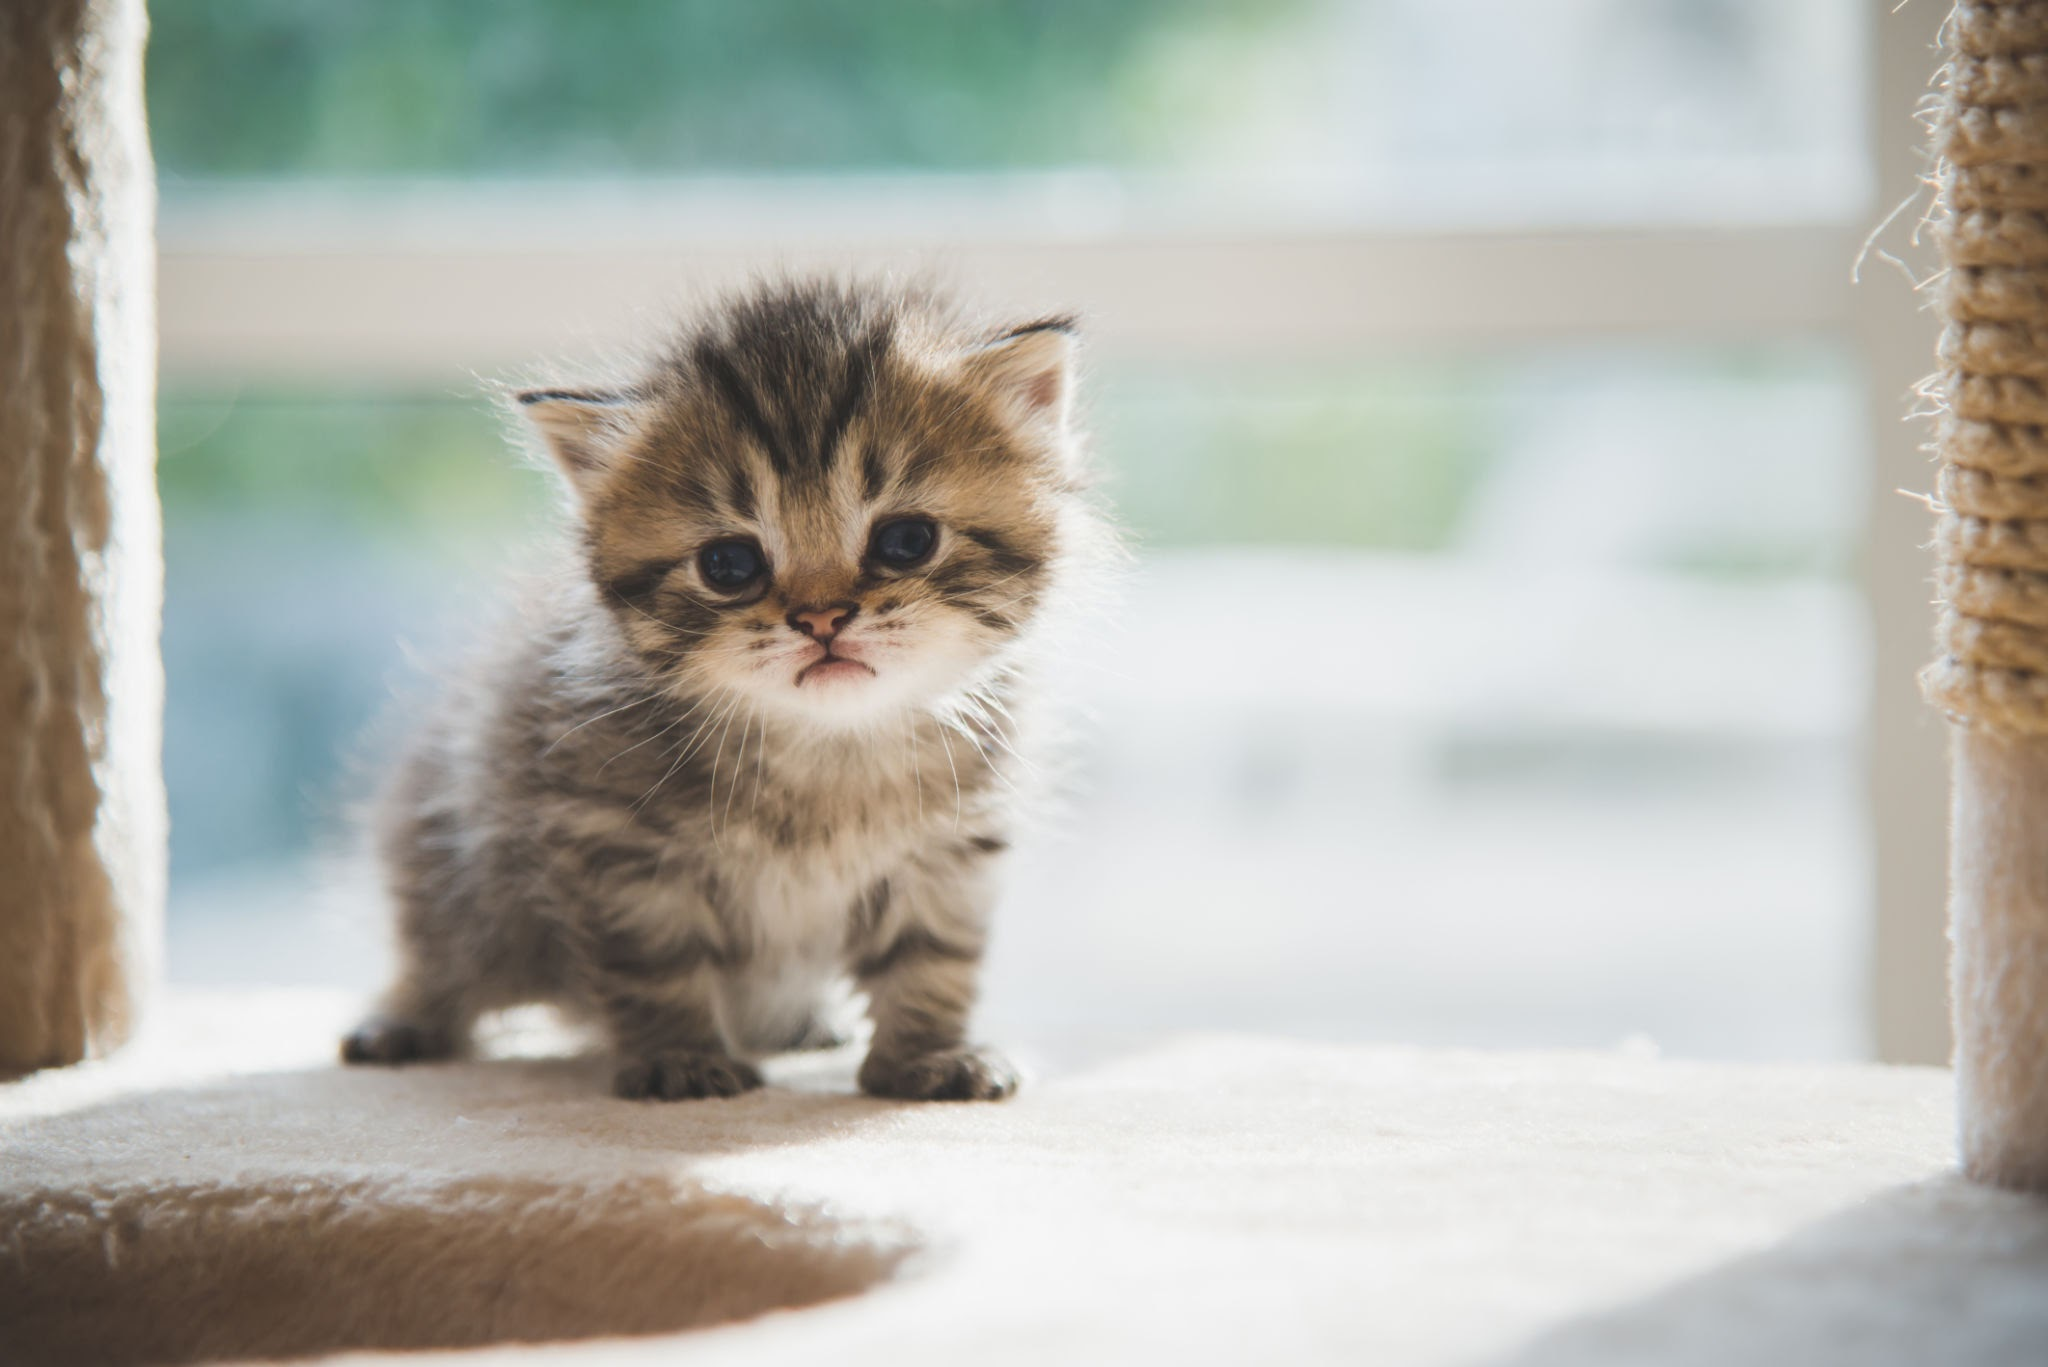

In [28]:
prediction = response.predictions[0]
prediction = dict(sorted(prediction.items(), key=lambda item: item[1], reverse=True))

print(prediction)
image = Image.open("kitten.jpeg")
image

## Make batch predictions

### Create the batch input file

You create a batch input file in JSONL format and store the input file in your Cloud Storage bucket.

Learn more about [Input data requirements](https://cloud.google.com/vertex-ai/docs/predictions/get-predictions#input_data_requirements).

In [ ]:
TEST_IMAGE_SIZE = 2
test_image_list = []
for i in range(TEST_IMAGE_SIZE):
    test_image_list.append(str(images_files[i]))

gcs_input_uri = f"{BUCKET_URI}/test_images.json"

with tf.io.gfile.GFile(gcs_input_uri, "w") as f:
    for test_image in test_image_list:
        with open(test_image, "rb") as image_f:
            data = {"data": base64.b64encode(image_f.read()).decode("utf-8")}
            f.write(json.dumps(data) + "\n")

### Submit a batch prediction job

In [ ]:
JOB_DISPLAY_NAME = f"{model_name}_batch_predict_job_unique"

batch_predict_job = deployed_model.batch_predict(
    job_display_name=JOB_DISPLAY_NAME,
    gcs_source=gcs_input_uri,
    gcs_destination_prefix=BUCKET_URI,
    instances_format="jsonl",
    model_parameters=None,
    machine_type=DEPLOY_COMPUTE,
)

### Get batch predictions

After the batch job completes, the results are written to the Cloud Storage output bucket you specified in the batch request. You call the method `iter_outputs()` to get a list of each Cloud Storage file generated with the results.

In [ ]:
bp_iter_outputs = batch_predict_job.iter_outputs()

prediction_files = list()
for blob in bp_iter_outputs:
    if blob.name.split("/")[-1].startswith("prediction.results"):
        prediction_files.append(blob.name)

In [ ]:
prediction_file = prediction_files[0]

results = []
gfile_name = f"{BUCKET_URI}/{prediction_file}"
with tf.io.gfile.GFile(name=gfile_name, mode="r") as gfile:
    for line in gfile.readlines():
        results.append(json.loads(line))

# Take one result as an example and print out the prediction.
prediction = results[0]["prediction"]
prediction = dict(sorted(prediction.items(), key=lambda item: item[1], reverse=True))
print(prediction)

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
endpoint.undeploy_all()
endpoint.delete()

deployed_model.delete()
batch_predict_job.delete()

delete_bucket = False
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI